# Classification Model Trial

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [17]:
# Importing Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from textblob import TextBlob
from dateutil.relativedelta import relativedelta
from datetime import datetime
import time
import dateutil.parser
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import torch
from transformers import BertTokenizer
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

[nltk_data] Downloading package punkt to C:\Users\visha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\visha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Articles

In [8]:
base_url = 'https://www.retaildive.com'
topic_urls = [
    "https://www.retaildive.com/search/"
]

def get_article_links(topic_url, page_number):
    url = f'{topic_url}?page={page_number}&q=Amazon'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_links = soup.select('.feed__title a')
    links = []
    for link in article_links:
        url = link['href'] if link['href'].startswith(base_url) else base_url + link['href']
        if url not in visited_urls:
            links.append(url)
            visited_urls.add(url)
    return links


pages_to_scrape = list(range(1, 10))

all_article_links = []
visited_urls = set()

for topic_url in topic_urls:
    for page_number in pages_to_scrape:
        article_links = get_article_links(topic_url, page_number)
        all_article_links.extend(article_links)

def parse_date(date_string):
    try:
        # Remove "Published " if it's present
        date_string = date_string.replace("Published ", "")
        
        # try to parse the date string using dateutil
        return dateutil.parser.parse(date_string)
    except ValueError:
        # if the date string is in an unrecognized format, return None
        return None

one_year_ago = datetime.now() - relativedelta(years=1)

crisis_keywords = ["Product recall", "Bankruptcy", "Store closure", "Data breach", "Supply chain disruption", "Strike",
                   "Labor dispute", "Boycott", "Fraud", "Inventory problem", "Lawsuit", "Regulatory violation",
                   "Health and safety violation", "Economic downturn", "Consumer complaint", "Public relations disaster",
                   "Security breach", "Outage", "Shipping disruption", "Production halt", "Brand crisis", "Profit warning",
                   "Recall", "Cyberattack", "Inflation", "Competition", "Loss of key partner", "Scandal", "Insolvency",
                   "Strike action", "Pandemic", "Natural disaster", "Product contamination", "Retail crisis", "Retail downturn",
                   "Retail bankruptcy", "Store closures", "Retail layoffs", "Falling sales", "Decreasing profits", "Overstock",
                   "Supply chain issues", "High retail vacancy", "E-commerce competition", "Online shopping surge",
                   "Brick-and-mortar decline", "Retail restructuring", "Retail debt", "Consumer behavior changes",
                   "Decreased foot traffic", "Retail disruption", "Shift to digital", "Retail insolvency", "Retail liquidation",
                   "Retail job cuts", "Retail industry collapse", "Retail market contraction", "Retail pandemic impact",
                   "Changes in retail trends", "Retail innovation challenges", "Omni-channel retailing struggles",
                   "Rising retail rent", "E-retail growth", "Retail technology adaptation", "Inventory management issues",
                   "Retail real estate crisis", "High street crisis", "Retail apocalypse", "Decline of shopping malls",
                   "Retail margin squeeze", "Loss of consumer confidence", "E-commerce crisis", "Online sales decline",
                   "E-commerce bankruptcy", "E-commerce fraud", "Data breach", "Cybersecurity threats", "Delivery issues",
                   "Supply chain disruptions", "Inventory management problems", "Consumer trust issues", "Decreased online traffic",
                   "Online customer retention issues", "Digital customer service complaints", "Payment gateway issues",
                   "E-commerce platform downtime", "Privacy concerns", "Negative online reviews", "E-commerce legal issues",
                   "Regulatory challenges for e-commerce", "Technology adaptation failures", "E-commerce site usability issues",
                   "Mobile commerce problems", "Social commerce challenges", "E-commerce return policy abuse", "International shipping issues",
                   "E-commerce tax issues", "Cross-border e-commerce difficulties", "E-commerce SEO problems",
                   "Lack of personalization in e-commerce", "Abandoned shopping carts", "E-commerce conversion rate decline",
                   "E-commerce accessibility issues", "E-commerce localization challenges", "Sustainability concerns in e-commerce",
                   "Product quality complaints", "E-commerce vendor disputes", "E-commerce advertising backlash", "Dropshipping difficulties",
                   "E-commerce platform migration problems", "Downfall"]

articles = []

for url in all_article_links:

#    response = requests.get(url)
    headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
    }
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.text, "html.parser")

    title_element = soup.find("h1", class_="display-heading-04")
    
    # If the title element is not found, skip the iteration
    if title_element is None or "Amazon" not in title_element.get_text(strip=True):
        continue

    title = title_element.get_text(strip=True)

    published_date = soup.find("span", class_="published-info").get_text(strip=True)
    published_date_parsed = parse_date(published_date)
#    print(published_date_parsed)
    article_body = soup.find("div", class_=["add-drop-cap large medium article-body", "large medium article-body"])

    # If the date is None or more than one year old, skip this article
    if published_date_parsed is None or published_date_parsed < one_year_ago:
#        print(f"Skipping article from {published_date_parsed}")
        continue

    if article_body:
        text_to_speech = article_body.find("div", class_="text-to-speech")
        if text_to_speech:
            text_to_speech.decompose()

        content = article_body.get_text(strip=True)

        # annotate with crisis keywords
        crisis_annotation = False
        for keyword in crisis_keywords:
            if keyword.lower() in content.lower():
                crisis_annotation = True
                break

        articles.append({
            "title": title,
            "published_date": published_date,
            "content": content,
            "url": url,
            "crisis_annotation": crisis_annotation,
        })
    else:
        articles.append({
            "title": title,
            "published_date": published_date,
            "content": "Content not found",
            "url": url,
            "crisis_annotation": False,
        })

    time.sleep(1)

df = pd.DataFrame(articles)
print(df)

                                                title  \
0                   Is Amazon done disrupting retail?   
1   As consumers return to stores, why would Amazo...   
2   Amazon continues to open suburban Go locations...   
3   Amazon buys mechatronics firm to fold into rob...   
4   Amazon offers sellers free software to speed f...   
..                                                ...   
94   Grove Collaborative expands into Walmart, Amazon   
95  Amazon rebrands discounted membership as it la...   
96            Amazon schedules Prime Day for mid-July   
97  What Amazon’s product updates say about its st...   
98           Amazon launches virtual try-on for shoes   

              published_date  \
0     Published Dec. 5, 2022   
1    Published July 25, 2022   
2    Published Feb. 13, 2023   
3   Published Sept. 14, 2022   
4   Published Sept. 20, 2022   
..                       ...   
94   Published Feb. 14, 2023   
95    Published Oct. 4, 2022   
96   Published June 16, 202

In [7]:
# Save as a CSV file
df.to_csv('retaildive_data.csv', index=False)

In [3]:
file_id = '1hFzsqf0YscjMCWmqrzs3Meu2PKcBSdNf'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

#df = pd.read_csv('retaildive_data.csv')

In [4]:
crisis_counts = df.groupby('crisis_annotation').count()
print(crisis_counts)

                   title  published_date  content  url
crisis_annotation                                     
False                 54              54       54   54
True                  45              45       45   45


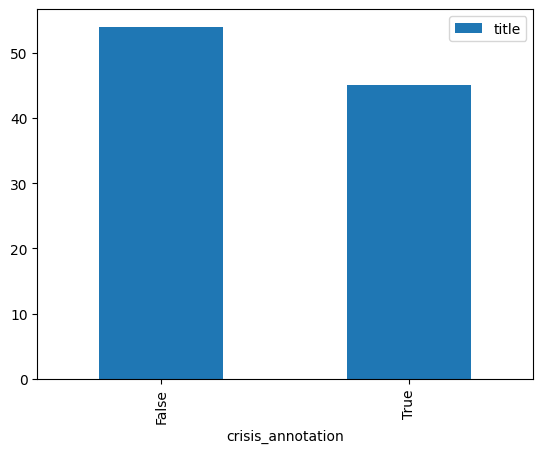

In [5]:
crisis_counts.plot(kind='bar', y='title')
plt.show()

### Data Cleaning and Preprocessing

In [5]:
# Check for missing values
print(df.isnull().sum())

# If there are missing values in the 'content' column, remove those rows
df = df.dropna(subset=['content'])

title                0
published_date       0
content              0
url                  0
crisis_annotation    0
dtype: int64


In [6]:
def clean_text(text):
    text = text.lower()                                                      # Convert text to lowercase
    text = re.sub(r'\[.*?\]', '', text)                                      # Remove text inside square brackets
    punctuation = string.punctuation.replace(':', '')                        # Create a new punctuation string without ':'
    text = re.sub(r'[%s]' % re.escape(punctuation), '', text)                # Remove punctuation marks using the new string
    text = re.sub(r'\w*\d\w*', '', text)                                     # Remove words containing numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)                        # Remove URLs
    text = re.sub(r'\W', ' ', text)                                          # Replace non-word characters with a space
    text = re.sub('[‘’“”…]', '', text)                                       # Remove special characters
    text = re.sub('\n', ' ', text)                                           # Replace newline characters with a space
    text = text.replace(':', ' ')                                            # Replace ':' with a space
    text = re.sub(r'[^\x00-\x7F]+', '', text)                                # Remove non-ASCII characters
    lemmatizer = WordNetLemmatizer()                                         # Create a WordNet lemmatizer object
    tokens = nltk.word_tokenize(text)                                        # Tokenize the text into individual words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]    # Lemmatize each token
    text = ' '.join(lemmatized_tokens)                                       # Join the lemmatized tokens back into a text
    
    return text


In [11]:
df['processed_content'] = df['content'].apply(lambda x: clean_text(x))
df['tokens'] = df['processed_content'].apply(word_tokenize)

In [12]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered = [word for word in tokens if word not in stop_words]
    return filtered

df['tokens'] = df['tokens'].apply(remove_stopwords)

In [34]:
#from nltk.stem import PorterStemmer

#stemmer = PorterStemmer()

#def apply_stemming(tokens):
#    return [stemmer.stem(token) for token in tokens]

#df['tokens'] = df['tokens'].apply(apply_stemming)

In [13]:
df['processed_content'] = df['tokens'].apply(' '.join)

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_articles(article):
    return tokenizer(article, padding='max_length', truncation=True, max_length=512)

# Apply the tokenize_articles function to the 'processed_content' column of the DataFrame
tokenized_articles = df['processed_content'].apply(tokenize_articles)

# Convert the tokenized output into separate columns in the DataFrame
df['input_ids'] = [torch.tensor(entry['input_ids']) for entry in tokenized_articles]
df['attention_mask'] = [torch.tensor(entry['attention_mask']) for entry in tokenized_articles]

# Convert crisis_annotation column to torch tensor
df['crisis_annotation'] = df['crisis_annotation'].apply(lambda x: torch.tensor(int(x)))

# Create a PyTorch Dataset from the DataFrame
class CrisisDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = self.df.loc[idx, 'input_ids']
        attention_mask = self.df.loc[idx, 'attention_mask']
        crisis_annotation = self.df.loc[idx, 'crisis_annotation']
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': crisis_annotation}

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = CrisisDataset(train_df)
val_dataset = CrisisDataset(val_df)

In [15]:
df

,title,published_date,content,url,crisis_annotation,processed_content,tokens,input_ids,attention_mask
0,Is Amazon done disrupting retail?,"Published Dec. 5, 2022",Amazon has spent the better part of a quarter ...,https://www.retaildive.com/news/amazon-done-di...,tensor(1),amazon ha spent better part quarter century fo...,"[amazon, ha, spent, better, part, quarter, cen...","[tensor(101), tensor(9733), tensor(5292), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,"As consumers return to stores, why would Amazo...","Published July 25, 2022",The pandemic supercharged e-commerce as even m...,https://www.retaildive.com/news/Why-amazon-shu...,tensor(1),pandemic supercharged ecommerce even consumer ...,"[pandemic, supercharged, ecommerce, even, cons...","[tensor(101), tensor(6090), tensor(3207), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,Amazon continues to open suburban Go locations...,"Published Feb. 13, 2023",Dive Brief:Amazon will expand its suburban Go ...,https://www.retaildive.com/news/amazon-go-open...,tensor(0),dive brief amazon expand suburban go cstore co...,"[dive, brief, amazon, expand, suburban, go, cs...","[tensor(101), tensor(11529), tensor(4766), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,Amazon buys mechatronics firm to fold into rob...,"Published Sept. 14, 2022",Dive Brief:Amazonsaid last weekit had agreed t...,https://www.retaildive.com/news/Amazon-buys-Cl...,tensor(0),dive brief amazonsaid last weekit agreed buy b...,"[dive, brief, amazonsaid, last, weekit, agreed...","[tensor(101), tensor(11529), tensor(4766), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,Amazon offers sellers free software to speed f...,"Published Sept. 20, 2022",Dive Brief:Amazonannounced Thursdayit would of...,https://www.retaildive.com/news/amazon-provide...,tensor(1),dive brief amazonannounced thursdayit would of...,"[dive, brief, amazonannounced, thursdayit, wou...","[tensor(101), tensor(11529), tensor(4766), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
...,...,...,...,...,...,...,...,...,...
94,"Grove Collaborative expands into Walmart, Amazon","Published Feb. 14, 2023","Expanding its wholesale channels, Grove Collab...",https://www.retaildive.com/news/grove-collabor...,tensor(0),expanding wholesale channel grove collaborativ...,"[expanding, wholesale, channel, grove, collabo...","[tensor(101), tensor(9186), tensor(17264), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
95,Amazon rebrands discounted membership as it la...,"Published Oct. 4, 2022",Dive Brief:Amazon unveiled a hub for discounts...,https://www.retaildive.com/news/amazon-launche...,tensor(1),dive brief amazon unveiled hub discount afford...,"[dive, brief, amazon, unveiled, hub, discount,...","[tensor(101), tensor(11529), tensor(4766), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
96,Amazon schedules Prime Day for mid-July,"Published June 16, 2022",Dive Brief:Prime Day this yearwill commenceat ...,https://www.retaildive.com/news/amazon-prime-d...,tensor(1),dive brief prime day yearwill commenceat midni...,"[dive, brief, prime, day, yearwill, commenceat...","[tensor(101), tensor(11529), tensor(4766), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
97,What Amazon’s product updates say about its st...,"Published Sept. 29, 2022",Amazon’s latest product announcements and upda...,https://www.retaildive.com/news/amazon-product...,tensor(0),amazon latest product announcement update wedn...,"[amazon, latest, product, announcement, update...","[tensor(101), tensor(9733), tensor(6745), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [16]:
!pip install --upgrade accelerate
!pip install --upgrade transformers

In [23]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Define function to compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # function to compute metrics
)

# Train the model
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

{'loss': 0.6774, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.0}


100%|██████████| 15/15 [06:49<00:00, 27.27s/it]

{'train_runtime': 409.0473, 'train_samples_per_second': 0.579, 'train_steps_per_second': 0.037, 'train_loss': 0.673853890101115, 'epoch': 3.0}


TrainOutput(global_step=15, training_loss=0.673853890101115, metrics={'train_runtime': 409.0473, 'train_samples_per_second': 0.579, 'train_steps_per_second': 0.037, 'train_loss': 0.673853890101115, 'epoch': 3.0})

In [24]:
evaluation_results = trainer.evaluate()
print(evaluation_results)

  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1/1 [00:00<00:00, 112.90it/s]

{'eval_loss': 0.6898715496063232, 'eval_accuracy': 0.45, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 13.635, 'eval_samples_per_second': 1.467, 'eval_steps_per_second': 0.073, 'epoch': 3.0}


In [26]:
# Evaluate the model
eval_results = evaluation_results

# Print evaluation results
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"F1 Score: {eval_results['eval_f1']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")

Accuracy: 0.45
F1 Score: 0.0
Precision: 0.0
Recall: 0.0


# Miscellaneous

In [40]:
pip install keras-tuner
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split

# Prepare your data

tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])
padded_sequences = pad_sequences(sequences, maxlen=200)

X = padded_sequences
y = df['topic_assignment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model within a function, as required by Keras Tuner
def build_model(hp):
    input_layer = Input(shape=(200,))
    x = Embedding(input_dim=5000, output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32))(input_layer)
    x = LSTM(hp.Int('lstm_units', min_value=32, max_value=512, step=32))(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(input_layer, output_layer)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='TextGen'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

,1: Date/Time,2: Tweet,3: Hashtags,14: Tweets,processed_content,tokens
0,5/11/2023 4:44 AM,Fear grows with each new vanishing. People bel...,booklaunch\nfantasy\nIARTG\nAmazon,8495,fear grows with each new vanishing people beli...,"[fear, grows, with, each, new, vanishing, peop..."
1,5/11/2023 4:44 AM,Struggling With Mental Health? Cope. What Colo...,Amazon\nStu\nAnxiety\nMotivation\nPsychology\n...,179147,struggling with mental health cope what color ...,"[struggling, with, mental, health, cope, what,..."
2,5/11/2023 4:43 AM,"AI answer to the question ""Who can I sell this...",artificialintelligence\namazon\nmicrosoft\nfac...,205,ai answer to the question who can i sell this ...,"[ai, answer, to, the, question, who, can, i, s..."
3,5/11/2023 4:42 AM,#Hermones 4 #womenshealth #Womens suffering fr...,Hermones\nwomenshealth\nWomens\npcos\npcod\nAm...,101,hermones womenshealth womens suffering from pc...,"[hermones, womenshealth, womens, suffering, fr..."
4,5/11/2023 4:42 AM,Check out this #Amazon Bestseller - Windows 10...,Amazon,210532,check out this amazon bestseller windows hp sf...,"[check, out, this, amazon, bestseller, windows..."
...,...,...,...,...,...,...
9995,5/10/2023 7:53 AM,📓Don’t Leave Your Money Behind 📷How Expats Can...,Behind\nMosesChavi\nbook\namazon\namazonbookma...,1898,dont leave your money behind how expats can es...,"[dont, leave, your, money, behind, how, expats..."
9996,5/10/2023 7:53 AM,"For a pair of shoelaces or something, I can un...",iPhone\namazon\ncustserv,33059,for a pair of shoelaces or something i can und...,"[for, a, pair, of, shoelaces, or, something, i..."
9997,5/10/2023 7:53 AM,Save 50.0% on select products from TIKTIK with...,Amazon\nClothing\nAccessories\nAd\nDeal\nBarga...,975,save on select products from tiktik with promo...,"[save, on, select, products, from, tiktik, wit..."
9998,5/10/2023 7:53 AM,📓Don’t Leave Your Money Behind\n💠How Expats Ca...,Behind\nFinancial\nMosesChavi\nbook\namazon\na...,1898,dont leave your money behind how expats can es...,"[dont, leave, your, money, behind, how, expats..."


In [113]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split

# Prepare your data

tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])
padded_sequences = pad_sequences(sequences, maxlen=200)

X = padded_sequences
y = df['topic_assignment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model within a function, as required by Keras Tuner
def build_model(hp):
    input_layer = Input(shape=(200,))
    x = Embedding(input_dim=5000, output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32))(input_layer)
    x = LSTM(hp.Int('lstm_units', min_value=32, max_value=512, step=32))(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(input_layer, output_layer)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), 
                  metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='TextGen'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Prepare the tokenizer on the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['content'])

# Convert texts into sequences of integers
sequences = tokenizer.texts_to_sequences(df['content'])

# The unique number of words
vocab_size = len(tokenizer.word_index) + 1

# Prepare input sequences
input_sequences = list()
for sequence in sequences:
    for i in range(1, len(sequence)):
        in_seq = sequence[:i+1]
        input_sequences.append(in_seq)

# Pad sequences for consistent length
max_length = max([len(seq) for seq in input_sequences])
sequences = pad_sequences(input_sequences, maxlen=max_length, padding='pre')

# Split sequences into input (X) and output (y)
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]

# One-hot encode the output variable
y = to_categorical(y, num_classes=vocab_size)

# Define the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length-1))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=100, verbose=1)

In [ ]:
import numpy as np

def generate_text(seed_text, model, tokenizer, max_length):
    in_text = seed_text
    for _ in range(100):  # Generate 100 words
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length-1, padding='pre')
        yhat = model.predict(encoded, verbose=0)
        predicted_index = np.argmax(yhat)  # Get the index of the word with highest probability
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                out_word = word
                break
        in_text += ' ' + out_word
    return in_text

# Example usage:
print(generate_text("This is a", model, tokenizer, max_length))